In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score

%matplotlib inline

# a function to draw a plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    sv = svc.support_vectors_
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [7]:
landmarks_ZRF_noNA = pd.read_csv('./data/tidyLandmarks_no_na.csv')
landmarks_ZRF_noNA = landmarks_ZRF_noNA.drop(columns=['Unnamed: 0'])
landmarks_ZRF_noNA.head()

,landmark_index,sample_index,min_alpha,max_alpha,min_theta,max_theta,num,pts,r,stype
0,1,1,-14.29,-4.76,-0.79,0.00,50,1251,5.000388,mt-zrf
1,2,1,-14.29,-4.76,-1.57,-0.79,50,313,2.442931,mt-zrf
2,3,1,-14.29,-4.76,-2.36,-1.57,50,30,1.475318,mt-zrf
3,4,1,-14.29,-4.76,-3.14,-2.36,50,169,1.438607,mt-zrf
4,5,1,-14.29,-4.76,0.00,0.79,50,773,3.382828,mt-zrf


## SVM Method 

In [8]:
def svm_classification(landmarks, index):
    # filter out the landmarks needed
    chosenLandmark = landmarks[landmarks.landmark_index==index]
    chosenLandmark = chosenLandmark[np.isfinite(chosenLandmark['r'])]
    
    # create training and testing data
    X = chosenLandmark[['pts', 'r']]
    y = chosenLandmark['stype']
    y = y.replace(['mt-zrf'], 1)
    y = y.replace(['wt-zrf'], 0)
    
    # present the data
    '''plt.figure(figsize=(8, 5))
    plt.scatter(X.values[:,0], X.values[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()'''
    
    # find the best C value by cross-validation
    tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
    clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy')
    clf.fit(X.values, y.values)
    best_c = clf.best_params_['C']
    
    svc = SVC(C=best_c, kernel='linear')
    svc.fit(X, y)
    
    plot_svc(svc, X.values, y)
    
    prediction = svc.predict(X)
    # print confusion matrix
    print("confusion matrix: ")
    cm = confusion_matrix(y, prediction)
    cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
    print(cm_df)
    print('Classification Report: ')
    print(classification_report(y, 
                            prediction,
                            digits = 3))
    # print accuracy score
    print('Classification Accuracy: ')
    accuracy = f1_score(y, prediction)
    print(accuracy)
    
    return svc, accuracy

## Testing SVM Method 

index: 1


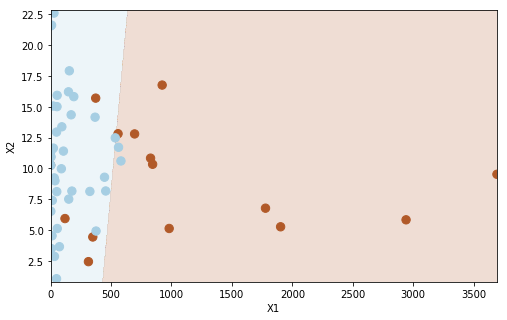

confusion matrix: 
    0   1
0  40   5
1   2  10
Classification Report: 
             precision    recall  f1-score   support

          0      0.889     0.952     0.920        42
          1      0.833     0.667     0.741        15

avg / total      0.874     0.877     0.872        57

Classification Accuracy: 
0.7407407407407408
0.7407407407407408


In [10]:
for i in range(1,2):
    print("index: " + str(i))
    svc, accuracy = svm_classification(landmarks_ZRF_noNA, i+1)
    print(accuracy)